In [1]:
from datetime import timedelta, date, datetime

import pandas as pd
from matplotlib import pyplot as plt

# Section: flux, label, is_live
sections: list[tuple[pd.Series, str, bool]] = []

In [3]:
"""
Load interesting sections from the archive data.
"""
from importer.archive import _from_timeseries, _select_best_source
from sunpy.timeseries import TimeSeries
from sunpy.net import Fido
from sunpy.net import attrs
from sunpy import config
import os
import glob

# Sample dates with various edge cases
ARCHIVE_DATES = (
    '1980-05-28', '1980-06-15', '1980-06-27', '1980-07-13',
    '1980-09-25', '1980-09-28', '1984-02-06', '1984-09-20',
    '1985-05-02', '1985-07-01', '1985-08-31', '1985-12-02',
    '1986-02-26', '1986-04-07', '1986-07-28', '1987-09-03',
    '1988-03-22', '1991-04-30', '1995-10-04', '1995-10-06',
    '1996-07-07', '2002-12-19', '2002-12-20', '2009-09-22',
    '2017-09-06'
)
ARCHIVE_SECTION_SIZE = timedelta(days=3)


def _search_cached(start: date, end: date) -> tuple[list[str], bool]:
    cache_dir = config.get('downloads', 'download_dir')
    dates = pd.date_range(start, end, freq='D')
    cached_files = []
    for sub_date in dates:
        for pattern in (
                f'go??{sub_date.strftime("%y%m%d")}.fits',
                f'sci_*xrs*-l2-*_g*_d{sub_date.strftime("%Y%m%d")}_v*.nc'
        ):
            candidates = glob.glob(os.path.join(cache_dir, pattern))
            if len(candidates) == 0:
                continue
            cached_files.append(candidates[0])
            break
    return cached_files, len(cached_files) == len(dates)


def _search_and_fetch(start: date, end: date):
    results = Fido.search(
        attrs.Time(start, end),
        attrs.Instrument("XRS")
    )
    results = _select_best_source(results)
    return Fido.fetch(results)


for date_str in ARCHIVE_DATES:
    start_date = date.fromisoformat(date_str)
    end_date = start_date + ARCHIVE_SECTION_SIZE
    print(f'Loading {start_date} to {end_date}')

    files, is_cache_complete = _search_cached(start_date, end_date)
    if is_cache_complete:
        print('Loading from cache')
    else:
        try:
            files = _search_and_fetch(start_date, end_date)
        except Exception as e:
            print(f'Failed to search and download {date_str}: {e}')
    if len(files) == 0:
        print('Download failed or no data found.')
        continue

    series = TimeSeries(files, concatenate=True)
    sections.append((
        _from_timeseries(series),
        date_str,
        False
    ))

Loading 1980-05-28 to 1980-05-31
Loading from cache
Loading 1980-06-15 to 1980-06-18
Loading from cache
Loading 1980-06-27 to 1980-06-30
Loading from cache
Loading 1980-07-13 to 1980-07-16
Loading from cache
Loading 1980-09-25 to 1980-09-28
Loading from cache
Loading 1980-09-28 to 1980-10-01
Loading from cache
Loading 1984-02-06 to 1984-02-09
Loading from cache
Loading 1984-09-20 to 1984-09-23
Loading from cache
Loading 1985-05-02 to 1985-05-05
Loading from cache
Loading 1985-07-01 to 1985-07-04
Loading from cache
Loading 1985-08-31 to 1985-09-03
Loading from cache
Loading 1985-12-02 to 1985-12-05
Loading from cache
Loading 1986-02-26 to 1986-03-01
Loading from cache
Loading 1986-04-07 to 1986-04-10
Loading from cache
Loading 1986-07-28 to 1986-07-31
Loading from cache
Loading 1987-09-03 to 1987-09-06
Loading from cache
Loading 1988-03-22 to 1988-03-25
Loading from cache
Loading 1991-04-30 to 1991-05-03
Loading from cache
Loading 1995-10-04 to 1995-10-07


Files Downloaded:   0%|          | 0/3 [00:00<?, ?file/s]

Loading 1995-10-06 to 1995-10-09


Files Downloaded:   0%|          | 0/2 [00:00<?, ?file/s]

Loading 1996-07-07 to 1996-07-10
Loading from cache
Loading 2002-12-19 to 2002-12-22
Loading from cache
Loading 2002-12-20 to 2002-12-23
Loading from cache
Loading 2009-09-22 to 2009-09-25
Loading from cache
Loading 2017-09-06 to 2017-09-09
Loading from cache


In [2]:
"""
Load all live data currently in the database.
Is a separate case because it is minute averaged.
"""
from data.flux.source import FluxSource
from data.db import connect_db
from data.flux.access import fetch_flux

connection = await connect_db()
live_flux = await fetch_flux(
    connection,
    FluxSource.LIVE,
    timedelta(minutes=1),
    datetime(2000, 1, 1),
    datetime.now()
)
sections.append((live_flux, 'live', True))

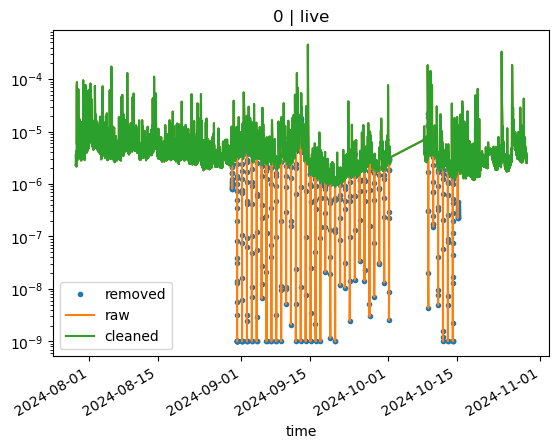

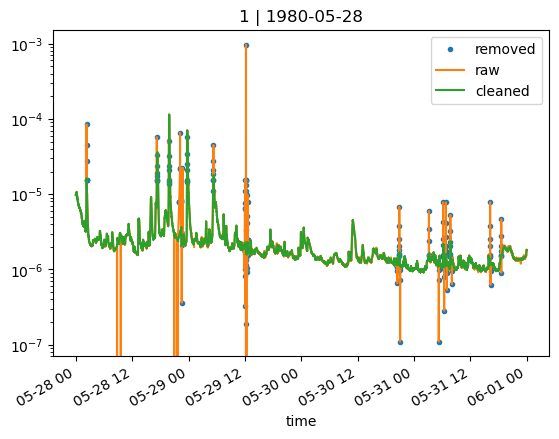

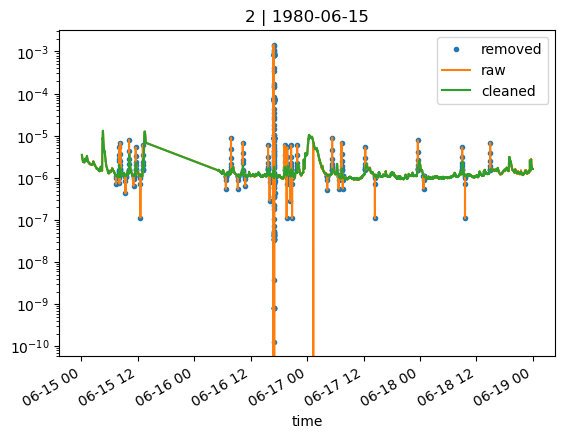

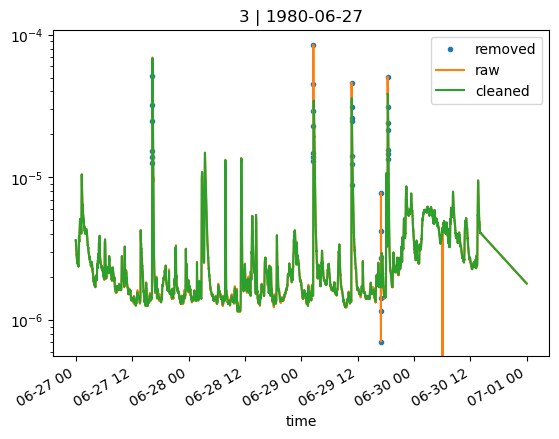

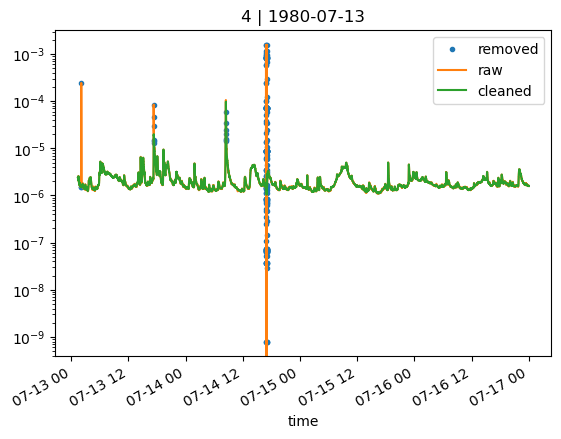

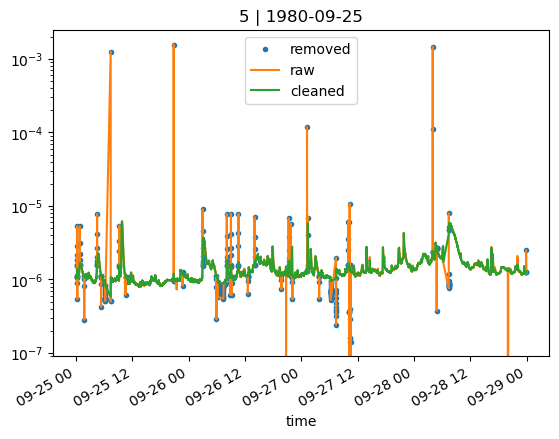

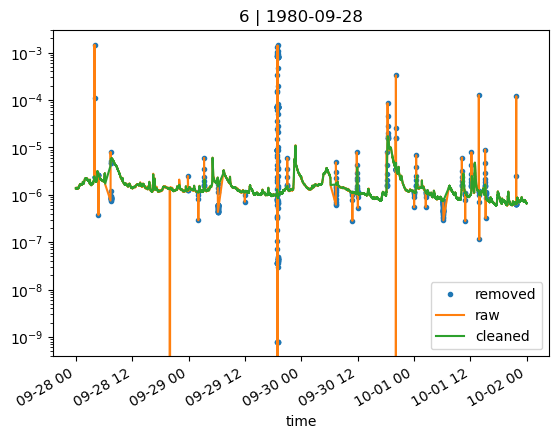

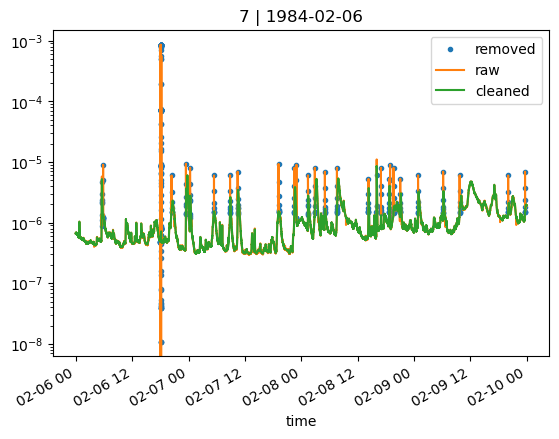

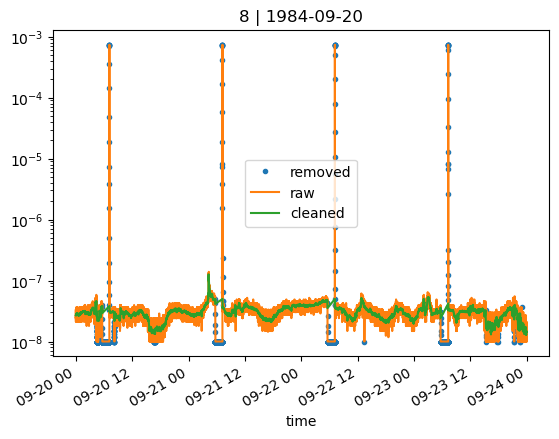

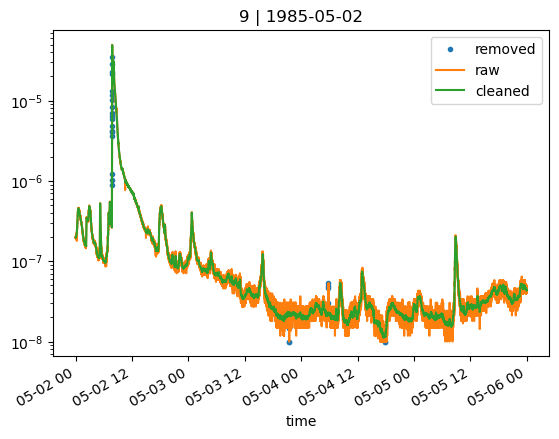

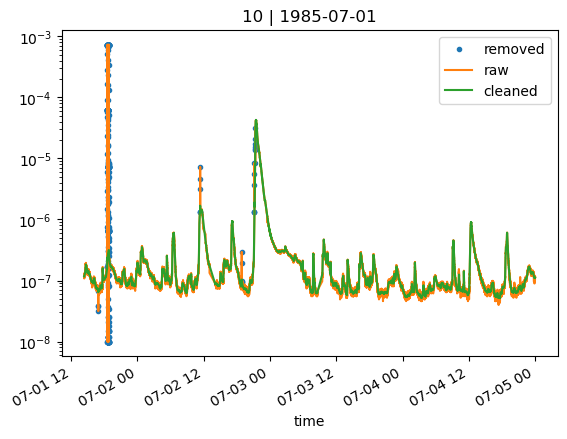

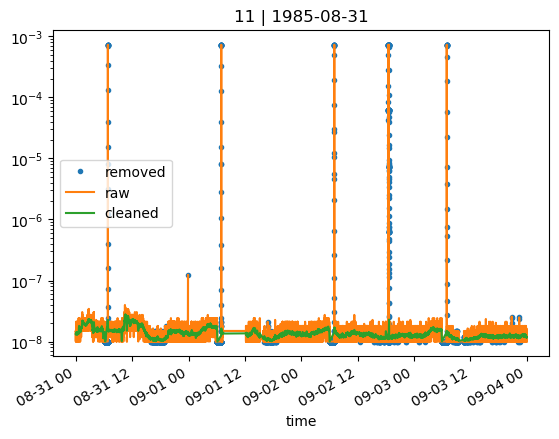

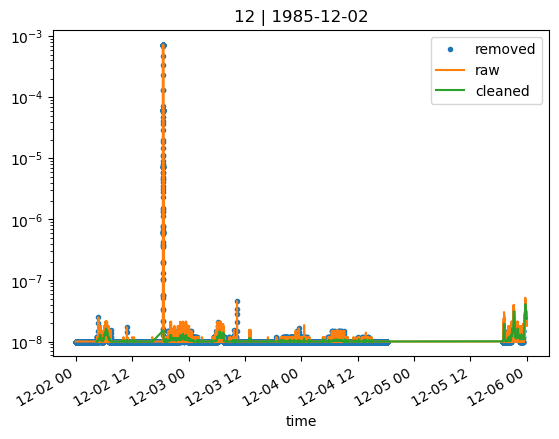

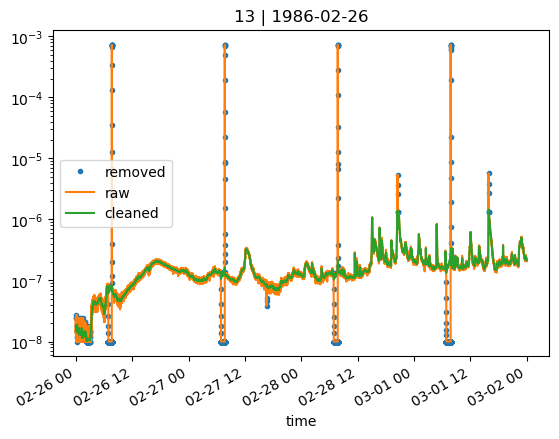

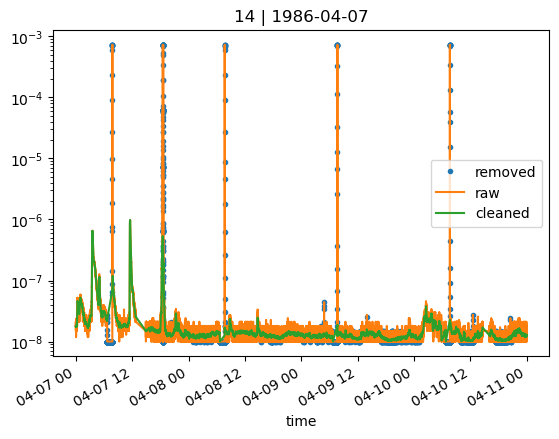

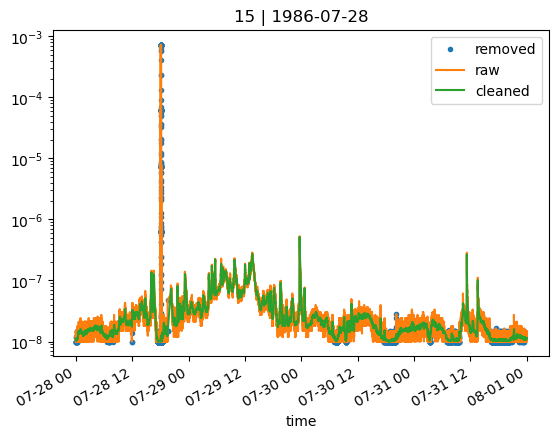

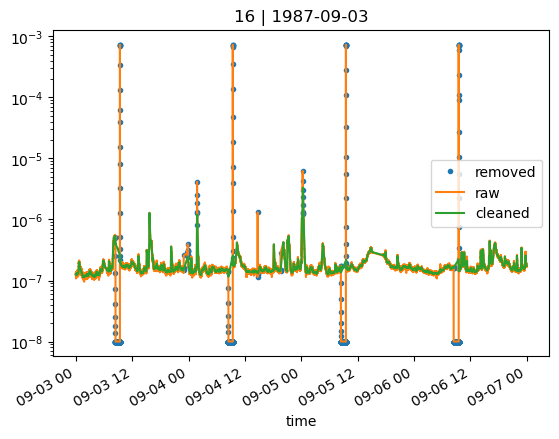

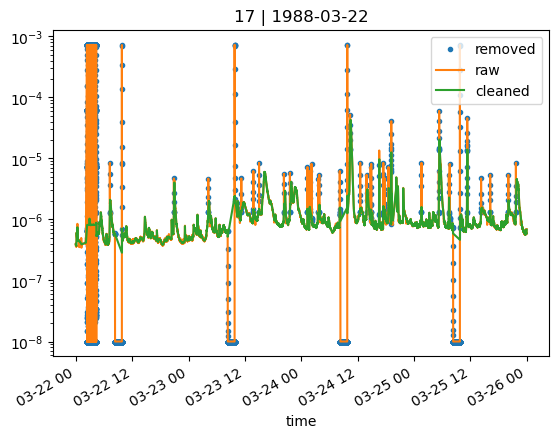

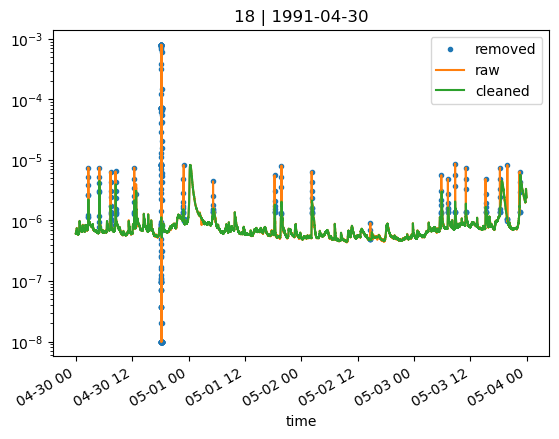

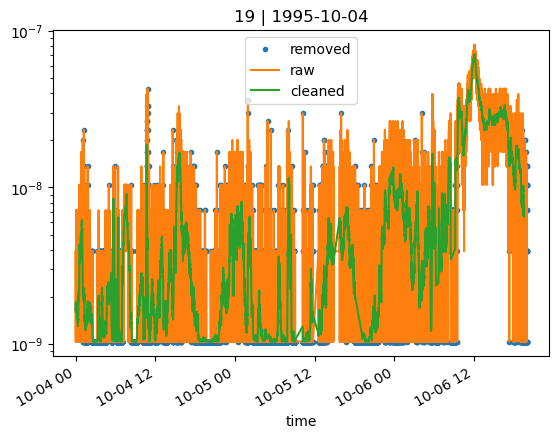

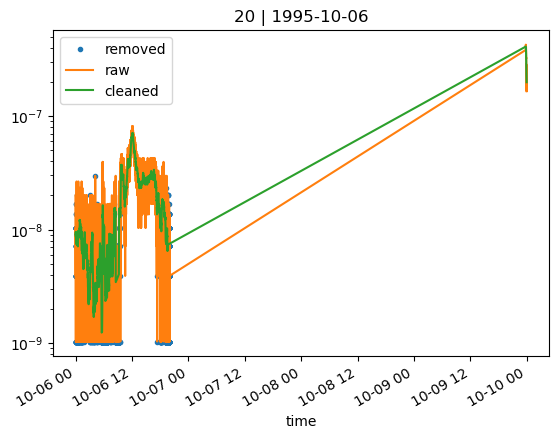

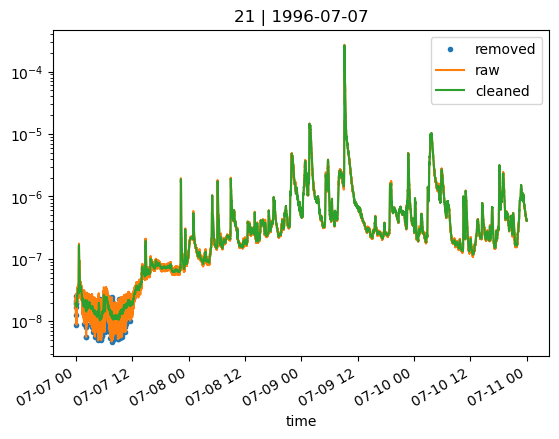

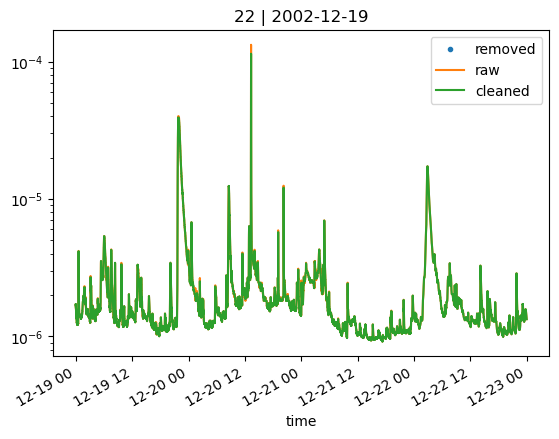

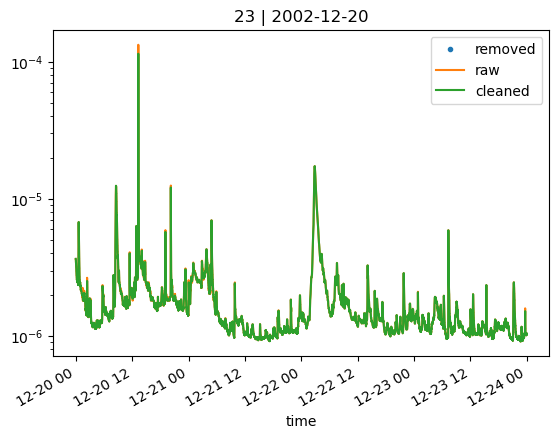

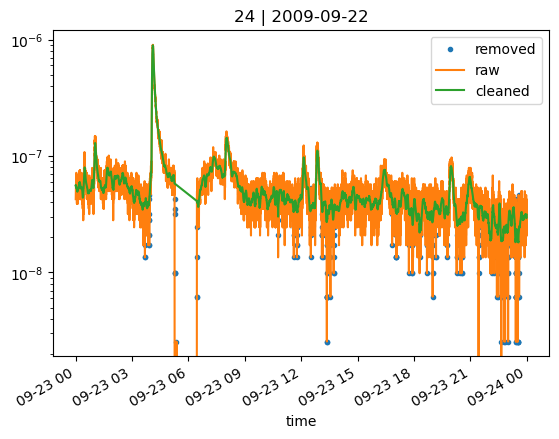

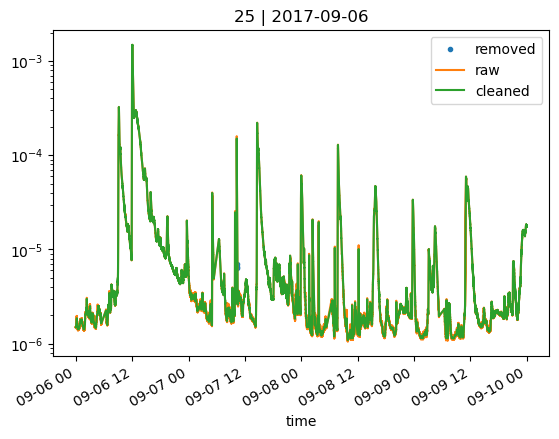

In [23]:
import importlib
import importer._clean as clean_module

# Reload clean module for easier development
importlib.reload(clean_module)
clean_flux = clean_module.clean_flux

for i, (raw, label, is_live) in enumerate(sections):
    cleaned = clean_flux(raw, is_live)
    ax = raw[~raw.index.isin(cleaned.index)].plot(
        title=f'{i} | {label}',
        logy=True,
        marker='.',
        linestyle='none',
        label='removed'
    )
    raw.rename('raw').plot(ax=ax)
    cleaned.rename('cleaned').plot(ax=ax)
    plt.legend()
    plt.show()